In [147]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
%matplotlib inline
import statsmodels as sm
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams

In [3]:
dataset = pd.read_csv("Final.csv")
dataset.head(10)

,Patient_ID,PerformedDate,Name_calc,Albumin/Creatinine_Res,Lipids_Res,a1c_Res,BP_res,A1C_RF,BP_RF,Lip_RF,Alb_RF,Total_RF
0,1.000100e+12,2017-11-02,Urine Albumin/Creatinine Ratio (ACR),392.0,NaN,NaN,NaN,0,0.0,0.0,3,3.0
1,1.000100e+12,2017-10-16,Urine Albumin/Creatinine Ratio (ACR),221.0,NaN,NaN,NaN,0,0.0,0.0,3,3.0
2,1.000100e+12,2014-04-07,Urine Albumin/Creatinine Ratio (ACR),9.0,NaN,NaN,NaN,0,0.0,0.0,2,2.0
3,1.000100e+12,2014-03-07,Urine Albumin/Creatinine Ratio (ACR),8.0,NaN,NaN,NaN,0,0.0,0.0,2,2.0
4,1.000100e+12,2014-02-05,Urine Albumin/Creatinine Ratio (ACR),9.0,NaN,NaN,NaN,0,0.0,0.0,2,2.0
5,1.000100e+12,2014-01-17,Urine Albumin/Creatinine Ratio (ACR),61.0,NaN,NaN,NaN,0,0.0,0.0,3,3.0
6,1.000100e+12,2019-04-07,Urine Albumin/Creatinine Ratio (ACR),197.0,NaN,NaN,NaN,0,0.0,0.0,3,3.0
7,1.000100e+12,2019-03-13,Urine Albumin/Creatinine Ratio (ACR),163.0,NaN,NaN,NaN,0,0.0,0.0,3,3.0
8,1.000100e+12,2015-09-01,Urine Albumin/Creatinine Ratio (ACR),7.0,NaN,NaN,NaN,0,0.0,0.0,2,2.0
9,1.000100e+12,2015-07-13,Urine Albumin/Creatinine Ratio (ACR),3.0,NaN,NaN,NaN,0,0.0,0.0,1,1.0


In [4]:
datasetNew = dataset.drop(['Patient_ID', 'Name_calc', 'a1c_Res', 'Lipids_Res','Total_RF', 'BP_res'], axis=1)
datasetNew = datasetNew.drop(['A1C_RF', 'BP_RF', 'Lip_RF', 'Alb_RF'], axis=1)
datasetNew['PerformedDate'] = pd.to_datetime(datasetNew['PerformedDate'], infer_datetime_format=True)
#indexedDataset = datasetNew.set_index(['PerformedDate'])

In [5]:
indexedDataset = datasetNew.rename(columns={"Albumin/Creatinine_Res": "Albumin"})

Filtering out values above/und

In [9]:
filt_df = indexedDataset.loc[:, indexedDataset.columns != 'PerformedDate']
low = .25
high = .75

quant_df = filt_df.quantile([low, high])
print(quant_df)
filt_df = filt_df.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
                                    (x < quant_df.loc[high,x.name])], axis=0)
filt_df = pd.concat([indexedDataset.loc[:,'PerformedDate'], filt_df], axis=1)
filt_df.dropna(inplace=True)
print(filt_df)

      Albumin
0.25      7.0
0.75     94.0
       PerformedDate  Albumin
2         2014-04-07      9.0
3         2014-03-07      8.0
4         2014-02-05      9.0
5         2014-01-17     61.0
11        2018-01-02     15.0
...              ...      ...
544841    2014-11-19     17.0
544842    2019-01-11     34.0
544843    2019-02-21      8.0
544846    2016-12-15     15.0
544847    2017-02-16     19.0

[247748 rows x 2 columns]


In [10]:
indexedDataset = filt_df.set_index(['PerformedDate'])

In [11]:
from datetime import datetime

In [12]:
print(indexedDataset)

               Albumin
PerformedDate         
2014-04-07         9.0
2014-03-07         8.0
2014-02-05         9.0
2014-01-17        61.0
2018-01-02        15.0
...                ...
2014-11-19        17.0
2019-01-11        34.0
2019-02-21         8.0
2016-12-15        15.0
2017-02-16        19.0

[247748 rows x 1 columns]


In [13]:
indexedDataset = indexedDataset.dropna()

In [14]:
indexedDataset.index = pd.to_datetime(indexedDataset.index)
indexedDataset = indexedDataset.sort_index()
print(indexedDataset)

               Albumin
PerformedDate         
1999-01-28         8.0
1999-11-18        58.0
1999-11-25        27.0
1999-12-20        10.0
2000-02-07        42.0
...                ...
2019-12-31         8.0
2019-12-31        18.0
2019-12-31        26.0
2019-12-31         8.0
2019-12-31        24.0

[247748 rows x 1 columns]


In [15]:
import math

               Albumin
PerformedDate         
2018-03-01        24.0
2018-03-01         9.0
2018-03-01        26.0
2018-03-01        62.0
2018-03-01         8.0
...                ...
2018-04-30        58.0
2018-04-30        12.0
2018-04-30        11.0
2018-04-30        14.0
2018-04-30        19.0

[5765 rows x 1 columns]


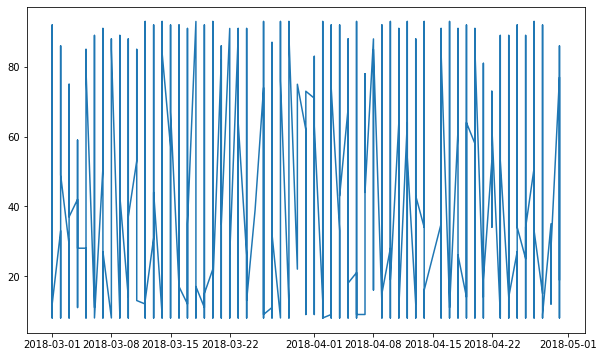

In [70]:
sub = indexedDataset['2018-03' : '2018-04']
print(sub)
plt.plot(sub)

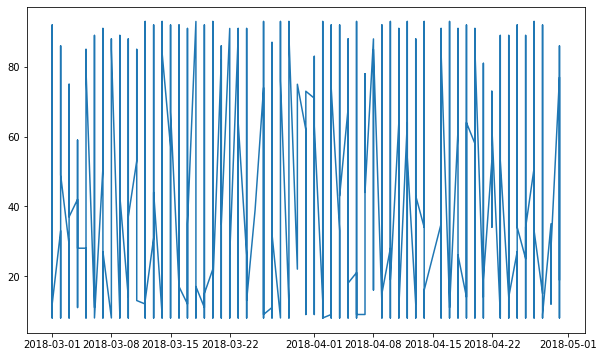

In [71]:
from scipy import stats
new = sub[(np.abs(stats.zscore(sub['Albumin'])) < 3)]
new2 = new.loc[(new!=0).any(axis=1)]
plt.plot(new2)

In [72]:
new2.head(30)

,Albumin
PerformedDate,
2018-03-01,24.0
2018-03-01,9.0
2018-03-01,26.0
2018-03-01,62.0
2018-03-01,8.0
2018-03-01,38.0
2018-03-01,46.0
2018-03-01,13.0
2018-03-01,24.0


In [142]:
##Finding range of values## 
print(new2.max())
print(new2.min())

Albumin    93.0
dtype: float64
Albumin    8.0
dtype: float64


In [123]:
indexedDataset == new2
print(indexedDataset)

               Albumin
PerformedDate         
2018-03-01        24.0
2018-03-01         9.0
2018-03-01        26.0
2018-03-01        62.0
2018-03-01         8.0
...                ...
2018-04-30        58.0
2018-04-30        12.0
2018-04-30        11.0
2018-04-30        14.0
2018-04-30        19.0

[5765 rows x 1 columns]


In [99]:
#Determing rolling statistics
rolmean = new2.rolling(window=12).mean()
rolstd = new2.rolling(window=12).std()
print(rolmean, rolstd)

                 Albumin
PerformedDate           
2018-03-01           NaN
2018-03-01           NaN
2018-03-01           NaN
2018-03-01           NaN
2018-03-01           NaN
...                  ...
2018-04-30     36.583333
2018-04-30     36.166667
2018-04-30     36.083333
2018-04-30     32.500000
2018-04-30     27.833333

[5765 rows x 1 columns]                  Albumin
PerformedDate           
2018-03-01           NaN
2018-03-01           NaN
2018-03-01           NaN
2018-03-01           NaN
2018-03-01           NaN
...                  ...
2018-04-30     25.047077
2018-04-30     25.440960
2018-04-30     25.528801
2018-04-30     25.343100
2018-04-30     21.699742

[5765 rows x 1 columns]


In [100]:
indexedDataset_logScale = np.log(new2)
print(indexedDataset_logScale)

                Albumin
PerformedDate          
2018-03-01     3.178054
2018-03-01     2.197225
2018-03-01     3.258097
2018-03-01     4.127134
2018-03-01     2.079442
...                 ...
2018-04-30     4.060443
2018-04-30     2.484907
2018-04-30     2.397895
2018-04-30     2.639057
2018-04-30     2.944439

[5765 rows x 1 columns]


In [101]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
print(movingAverage, movingSTD)

                Albumin
PerformedDate          
2018-03-01          NaN
2018-03-01          NaN
2018-03-01          NaN
2018-03-01          NaN
2018-03-01          NaN
...                 ...
2018-04-30     3.340539
2018-04-30     3.311514
2018-04-30     3.304263
2018-04-30     3.187263
2018-04-30     3.072843

[5765 rows x 1 columns]                 Albumin
PerformedDate          
2018-03-01          NaN
2018-03-01          NaN
2018-03-01          NaN
2018-03-01          NaN
2018-03-01          NaN
...                 ...
2018-04-30     0.789925
2018-04-30     0.816223
2018-04-30     0.824577
2018-04-30     0.809693
2018-04-30     0.728390

[5765 rows x 1 columns]


In [102]:
# Get the difference between the moving average and the actual number of passengers
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)
#Remove Nan Values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Albumin
PerformedDate,
2018-03-01,-0.427191
2018-03-01,0.554499
2018-03-01,-1.162907
2018-03-01,0.433267
2018-03-01,-0.585173
2018-03-01,-1.070681
2018-03-01,-0.427855
2018-03-01,0.511211
2018-03-01,1.174936


In [103]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Albumin'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

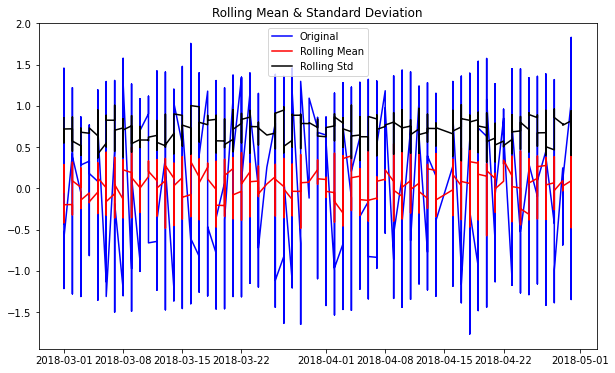

Results of Dickey-Fuller Test:
Test Statistic                  -20.652789
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5720.000000
Critical Value (1%)              -3.431494
Critical Value (5%)              -2.862045
Critical Value (10%)             -2.567039
dtype: float64


In [104]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000000000
test_stationarity(datasetLogScaleMinusMovingAverage)

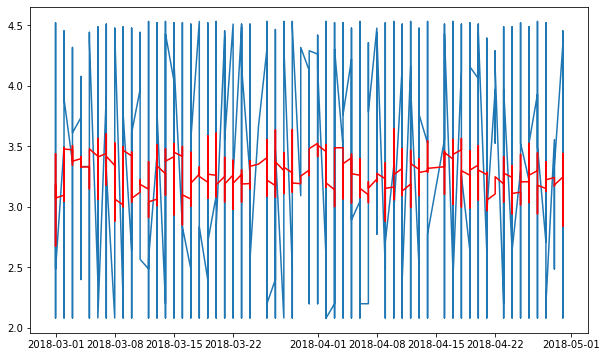

In [105]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

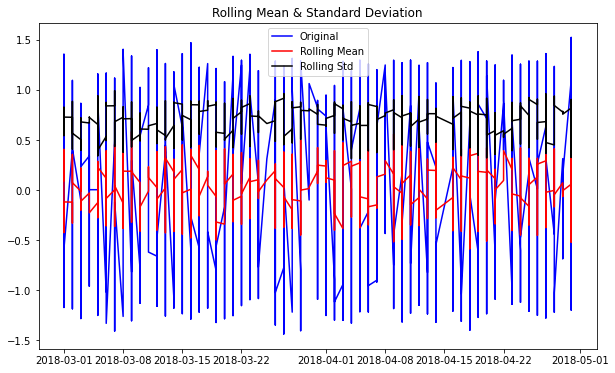

Results of Dickey-Fuller Test:
Test Statistic                  -19.343344
p-value                           0.000000
#Lags Used                       25.000000
Number of Observations Used    5739.000000
Critical Value (1%)              -3.431490
Critical Value (5%)              -2.862044
Critical Value (10%)             -2.567038
dtype: float64


In [106]:
datasetLogScaleMinusMovingExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

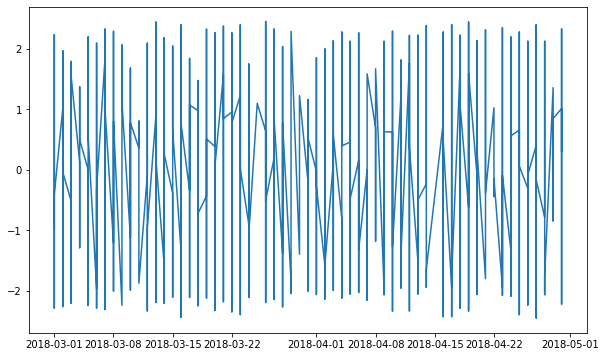

In [107]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

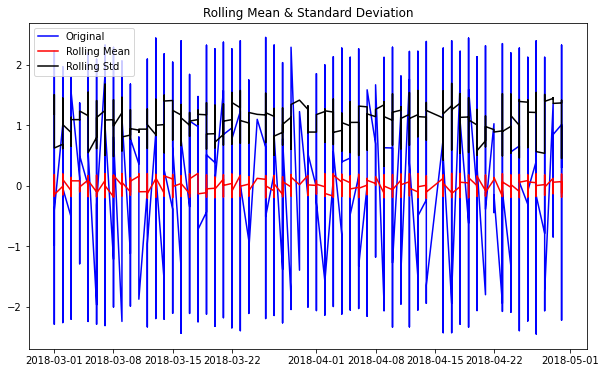

Results of Dickey-Fuller Test:
Test Statistic                  -22.291954
p-value                           0.000000
#Lags Used                       34.000000
Number of Observations Used    5729.000000
Critical Value (1%)              -3.431492
Critical Value (5%)              -2.862045
Critical Value (10%)             -2.567039
dtype: float64


In [108]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

In [149]:
import statsmodels.api as sm

In [152]:
print(indexedDataset_logScale)

                Albumin
PerformedDate          
2018-03-01     3.178054
2018-03-01     2.197225
2018-03-01     3.258097
2018-03-01     4.127134
2018-03-01     2.079442
...                 ...
2018-04-30     4.060443
2018-04-30     2.484907
2018-04-30     2.397895
2018-04-30     2.639057
2018-04-30     2.944439

[5765 rows x 1 columns]


<ipython-input-160-cece928415ad>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(411)
<ipython-input-160-cece928415ad>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(411)


               Albumin
PerformedDate         
2018-03-01         0.0
2018-03-01         0.0
2018-03-01         0.0
2018-03-01         0.0
2018-03-01         0.0
...                ...
2018-04-30         0.0
2018-04-30         0.0
2018-04-30         0.0
2018-04-30         0.0
2018-04-30         0.0

[5765 rows x 1 columns]


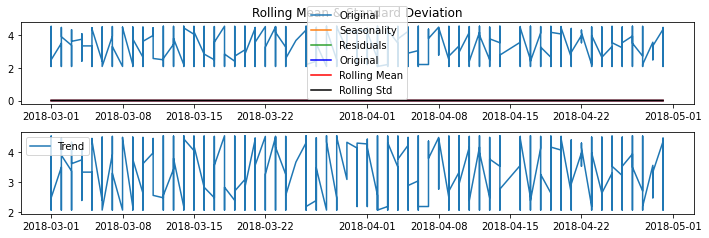

Results of Dickey-Fuller Test:
Test Statistic                         NaN
p-value                                NaN
#Lags Used                        0.000000
Number of Observations Used    5764.000000
Critical Value (1%)              -3.431485
Critical Value (5%)              -2.862042
Critical Value (10%)             -2.567037
dtype: float64


c:\users\susu1\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [160]:
decomposition = seasonal_decompose(indexedDataset_logScale, period = 1 ) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
s = pd.DataFrame(decomposedLogData)
df = s.rename(columns={"resid": "Albumin"})
print(df)
test_stationarity(df)

In [161]:
indexedDataset_logScale.index = pd.to_datetime(indexedDataset_logScale.index)

c:\users\susu1\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


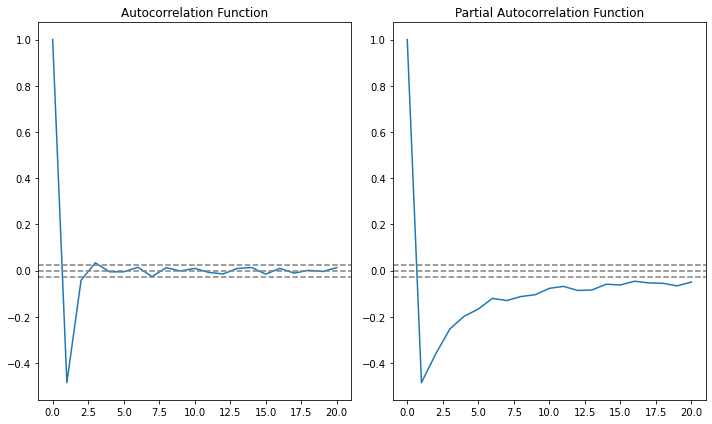

In [162]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            


c:\users\susu1\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\susu1\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Plotting AR model


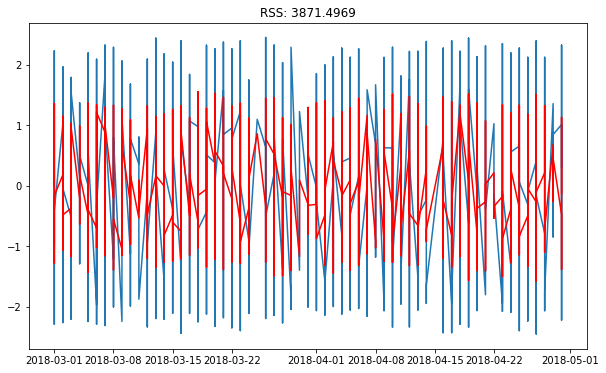

In [164]:
#AR Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(indexedDataset_logScale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Albumin'])**2))
print('Plotting AR model')

c:\users\susu1\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\susu1\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Plotting MA model


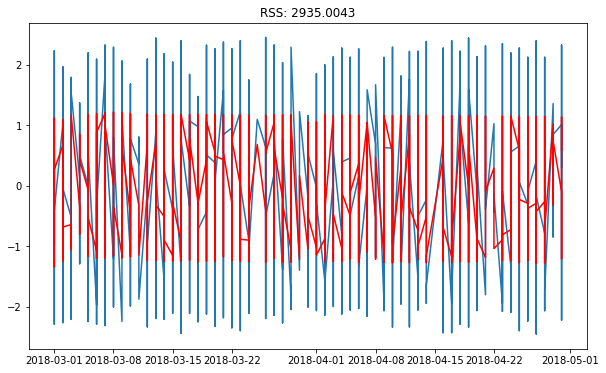

In [165]:
#MA MODEL
model = ARIMA(indexedDataset_logScale, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-datasetLogDiffShifting['Albumin'])**2))
print('Plotting MA model')

c:\users\susu1\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\susu1\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\susu1\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release

Text(0.5, 1.0, 'RSS: 2933.5258')

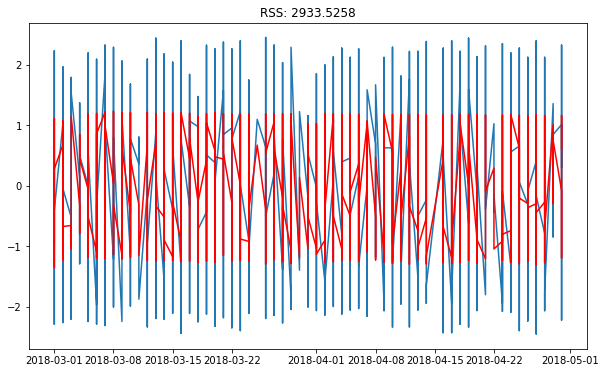

In [166]:
model = ARIMA(indexedDataset_logScale, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-datasetLogDiffShifting['Albumin'])**2))

In [167]:
predictions_ARIMA_diff = pd.Series(results_MA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

PerformedDate
2018-03-01   -0.000011
2018-03-01    0.486155
2018-03-01   -0.375061
2018-03-01   -0.927024
2018-03-01    0.879653
dtype: float64


In [168]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

PerformedDate
2018-03-01   -0.000011
2018-03-01    0.486145
2018-03-01    0.111084
2018-03-01   -0.815940
2018-03-01    0.063712
dtype: float64


In [169]:
#predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
#predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
#predictions_ARIMA_log.head()

predictions_ARIMA_log = pd.Series(indexedDataset_logScale.iloc[0,0],index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

PerformedDate
2018-03-01    3.178043
2018-03-01    3.664198
2018-03-01    3.289138
2018-03-01    2.362113
2018-03-01    3.241766
dtype: float64

In [170]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
print(predictions_ARIMA)

PerformedDate
2018-03-01    2.399975e+01
2018-03-01    3.902484e+01
2018-03-01    2.681973e+01
2018-03-01    1.061336e+01
2018-03-01    2.557885e+01
                  ...     
2018-04-30    1.370693e-15
2018-04-30    6.013180e-16
2018-04-30    1.257533e-15
2018-04-30    2.866707e-15
2018-04-30    5.144747e-15
Length: 729546, dtype: float64


In [171]:
j = (predictions_ARIMA-indexedDataset['Albumin'])**2
#print(j)
k = len(indexedDataset['Albumin'])
#print(k)
u = sum(j/k)
#print(u)
rmse = np.sqrt(u)

In [129]:
print(rmse)

5224.839535025133


Text(0.5, 1.0, 'RMSE: 5224.8395')

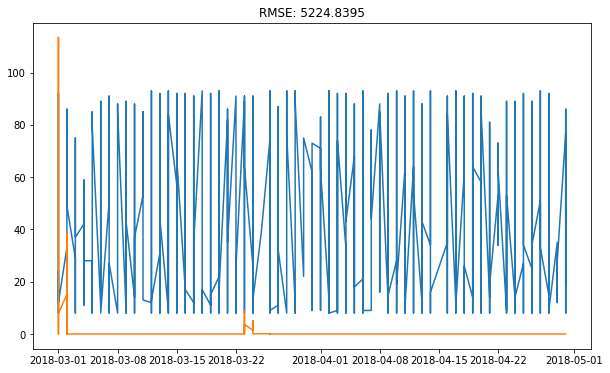

In [131]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(new2)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% rmse)